<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/220623_RNN_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/content/drive/MyDrive/deeplearningbro/kospi.csv")
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057
...,...,...,...,...,...,...,...
426,2020-10-26,0.909485,0.911124,0.911803,0.898908,2343.909912,0.414424
427,2020-10-27,0.870905,0.884388,0.890248,0.885652,2330.840088,0.336105
428,2020-10-28,0.866338,0.880277,0.885443,0.900278,2345.260010,0.355408
429,2020-10-29,0.854266,0.864035,0.868724,0.881423,2326.669922,0.256577


In [5]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#입력값, 라벨값 지정

### 데이터 프레임에서는 values를 이용하면 넘파이로 변환 가능


In [6]:
X = df[['Open','High','Low','Volume']].values #feature data
y = df[['Close']].values #target data 

## 시퀀스 생성 함수

### 시퀀스 순서 직접 값 넣어보기

In [7]:
def seq_data(x, y, sequence_length): #며칠 간격으로 볼 것인지 선택
    x_seq = [] #시퀀스 저장 빈리스트
    y_seq = [] 
    for i in range(len(x)-sequence_length): #값이 커짐
        x_seq.append(x[i:i+sequence_length])  #커진만큼 간격도 이동
        y_seq.append(y[i+sequence_length]) # 타겟은 다음날 값. 즉 마지막 값이다.
        
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1) 
    #float32 GPU텐서 변환 후 2차원으로 만듦
    #텐서 변수 초기화 때는 대문자 사용함. https://subinium.github.io/pytorch-Tensor-Variable/
    #MSE loss는 2차원 데이터를 타깃데이터로 받는다.

#### 200개는 학습용 데이터, 226개는 테스트용 데이터

In [8]:
split = 200
sequence_length = 5 # (sequence_length, 입력 변수의 개수) 만큼의 list가 (전체 데이터-sequence_length)번 추가
x_seq, y_seq = seq_data(X, y, sequence_length) 
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  


torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


### DataLoader

In [9]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)
batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size)

In [10]:
input_size = x_seq.size(2) #입력 변수의 개수(=변수의 크기)로 초기화
num_layers = 2 #은닉층의 개수
hidden_size = 8 #은닉상태 저장 벡터 크기

In [11]:
input_size

4

### 입력 사이즈, 변환 사이즈 확인

In [12]:
class VanilaRNN(nn.Module): #가장 기본이 되므로 바닐라라고 함
    #입력 [200, 5, 4] = [배치 사이즈, 변수의 크기, 시퀀스 길이]
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(VanilaRNN, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True) # RNN(시퀀스 길이, 배치사이즈, 변수의 크기) ?
        self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length,1),nn.Sigmoid()) 

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값을 크기만 맞추어서 0인 텐서로 형성
        out,_ = self.rnn(x, h0) # 반환은 예측값, 예측상태임. 뒤에 값을 버림
        # out => [20,5,8]
        out = out.reshape(out.shape[0],-1) 
        # out => [20,40]
        out = self.fc(out)
        # out => [20,1] fc했더니 40이 어떻게 1로 변했는지 혼동...

        return out

In [13]:
model = VanilaRNN(input_size = input_size,
                   hidden_size = hidden_size,
                   sequence_length = sequence_length,
                   num_layers = num_layers,
                   device = device).to(device) 

### Loss func & Optimizer

In [14]:
criterion = nn.MSELoss()
num_epochs = 301
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

### Model Train

In [15]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        seq, target = data # 배치 데이터
        seq = seq.to(device)
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 100 == 0:
        print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0173
[epoch : 100] loss: 0.0007
[epoch : 200] loss: 0.0005
[epoch : 300] loss: 0.0004


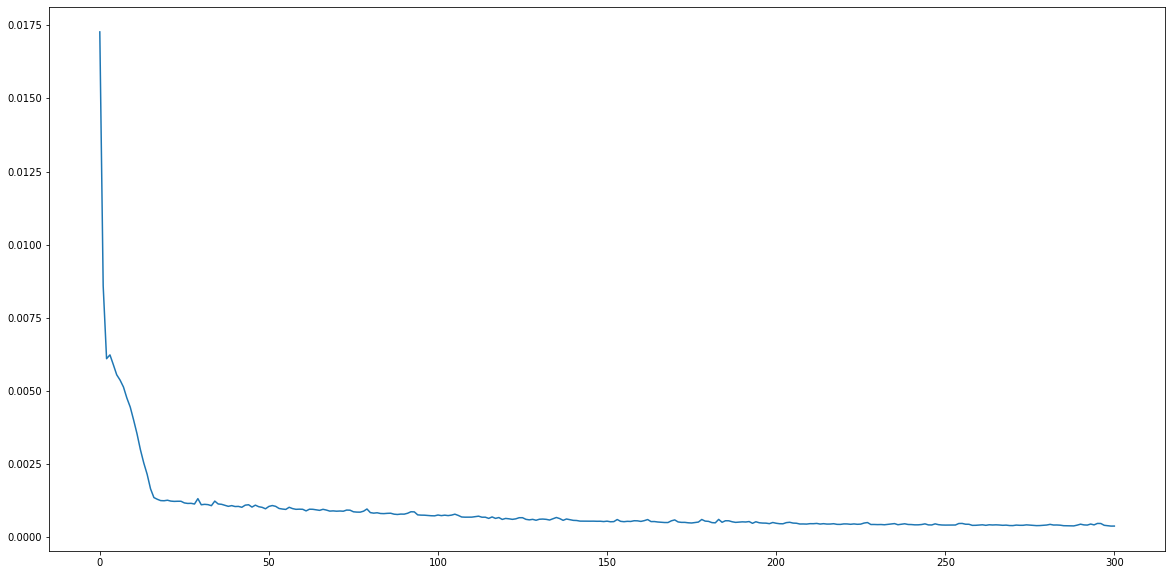

In [16]:
plt.figure(figsize = (20,10))
plt.plot(loss_graph)
plt.show()

### 주가 그래프 그리기

In [17]:
concatdata  = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)
with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred+=out.cpu().tolist()

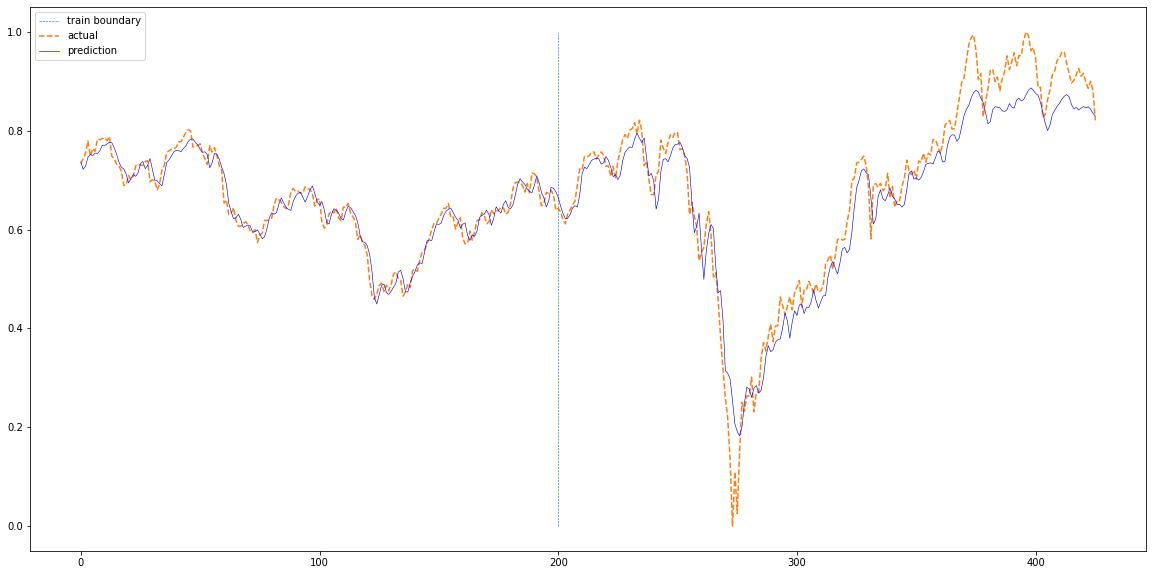

In [18]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100),'--', linewidth=0.6) #np.linspace(start, stop, num개수)로 훈련 데이터와 테스트 데이터의 구간 나눔
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b',linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

# 평가 부분은 급락하는 부분은 잡아내지 못한다.